In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import keras
import numpy as np
import os
from tqdm import tqdm
from time import time
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score,precision_recall_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter,defaultdict
from PIL import Image,ImageOps
import glob 
import cv2
import pickle
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass

For both PA and AP datasets:

1. Find the frequency distribution for each class (#samples per class)
2. Split into train/test/val datasets and save these as CSVs

3. On a sidenote, find the representation for each imagefile and ensure u reshape it into 128,128

# **PA Images**

## **Adding Full Paths and Some basic preprocessing**

In [ ]:
os.chdir("/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets/")
!pwd

/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets


In [ ]:
!ls

 AP_images.pkl			 Filter_Dataset_script.ipynb
 bin_files			 images
'csv files'			 images_rescaled
 Data_Entry_2017_v2020.gsheet	 images_zip_files
 Dataset_Process_Details.ipynb	 Sample_Set_Images.ipynb


In [ ]:
df_pa = pd.read_csv("csv files/with_sampling_index_csv/df_PA.csv")
df_pa

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,1
2,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,1
3,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,2
4,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
24337,00030427_001.png,No Finding,1,30427,70,M,PA,2021,2021,0.194311,0.194311,8113
24338,00030427_002.png,No Finding,2,30427,71,M,PA,2021,2021,0.194311,0.194311,8113
24339,00030434_000.png,Atelectasis,0,30434,53,M,PA,2021,2021,0.194308,0.194308,8114
24340,00030434_001.png,Atelectasis,1,30434,53,M,PA,2021,2021,0.194311,0.194311,8114


In [ ]:
len(df_pa['Sample #'].unique()) #number of samples for our project

8114

In [ ]:
my_glob = glob.glob('images/images*/*.png')
print('Number of Observations: ', len(my_glob)) # Number of photos should equal 112,120

In [ ]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
df_pa['full_path'] = df_pa['Image Index'].map(full_img_paths.get)
df_pa

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,1,images/images1/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,1,images/images1/00000001_001.png
2,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,1,images/images1/00000001_002.png
3,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,2,images/images1/00000001_000.png
4,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,2,images/images1/00000001_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24337,00030427_001.png,No Finding,1,30427,70,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_001.png
24338,00030427_002.png,No Finding,2,30427,71,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_002.png
24339,00030434_000.png,Atelectasis,0,30434,53,M,PA,2021,2021,0.194308,0.194308,8114,images/images12/00030434_000.png
24340,00030434_001.png,Atelectasis,1,30434,53,M,PA,2021,2021,0.194311,0.194311,8114,images/images12/00030434_001.png


In [ ]:
df_pa.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Sample #',
       'full_path'],
      dtype='object')

In [ ]:
df_pa.to_csv("csv files/with_sampling_index_csv/added_paths_PA.csv",index=False)

## **Train/ Test/ Validation dataset creation**

In [ ]:
sample_nums = df_pa['Sample #'].unique()
sample_nums

array([   1,    2,    3, ..., 8112, 8113, 8114])

In [ ]:
TEST_RATIO = 0.2 #20% test split

In [ ]:
#split by sample number; then we will
train_sample_nums,test_sample_nums = train_test_split(sample_nums,test_size = TEST_RATIO,random_state = 999)

In [ ]:
train_sample_nums

array([3361, 7564, 5458, ..., 4966, 4445, 5569])

In [ ]:
len(train_sample_nums)

6491

In [ ]:
test_sample_nums

array([1144, 1295, 5320, ..., 2207, 3560, 4270])

In [ ]:
len(test_sample_nums)

1623

In [ ]:
df_train_all = df_pa[df_pa['Sample #'].isin(train_sample_nums)]
df_test = df_pa[df_pa['Sample #'].isin(test_sample_nums)]

In [ ]:
df_train_all.reset_index(inplace = True,drop = True)
df_test.reset_index(inplace = True,drop = True)

In [ ]:
df_train_all

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,1,images/images1/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,1,images/images1/00000001_001.png
2,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,1,images/images1/00000001_002.png
3,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,2,images/images1/00000001_000.png
4,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,2,images/images1/00000001_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19468,00030350_001.png,No Finding,1,30350,24,M,PA,2021,2021,0.194311,0.194311,8112,images/images12/00030350_001.png
19469,00030350_002.png,No Finding,2,30350,25,M,PA,2021,2021,0.194311,0.194311,8112,images/images12/00030350_002.png
19470,00030427_000.png,No Finding,0,30427,70,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_000.png
19471,00030427_001.png,No Finding,1,30427,70,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_001.png


In [ ]:
len(df_train_all['Sample #'].unique())

6491

In [ ]:
df_test

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143000,0.143000,7,images/images1/00000003_003.png
1,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168000,0.168000,7,images/images1/00000003_004.png
2,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143000,0.143000,7,images/images1/00000003_005.png
3,00000103_005.png,Mass|Pneumothorax,5,103,60,M,PA,2992,2991,0.143000,0.143000,38,images/images1/00000103_005.png
4,00000103_006.png,Pneumothorax,6,103,60,M,PA,2992,2991,0.143000,0.143000,38,images/images1/00000103_006.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4864,00030068_002.png,Effusion,2,30068,59,F,PA,1841,2020,0.194311,0.194311,8110,images/images12/00030068_002.png
4865,00030068_003.png,Infiltration,3,30068,60,F,PA,2021,2021,0.194311,0.194311,8110,images/images12/00030068_003.png
4866,00030434_000.png,Atelectasis,0,30434,53,M,PA,2021,2021,0.194308,0.194308,8114,images/images12/00030434_000.png
4867,00030434_001.png,Atelectasis,1,30434,53,M,PA,2021,2021,0.194311,0.194311,8114,images/images12/00030434_001.png


In [ ]:
len(df_test['Sample #'].unique())

1623

In [ ]:
total_num_train_samples = len(df_train_all['Sample #'].unique())

In [ ]:
train_final_samples = train_sample_nums[:-int(0.1 * total_num_train_samples)]
val_samples = train_sample_nums[-int(0.1 * total_num_train_samples):]

In [ ]:
len(train_final_samples)

5842

In [ ]:
train_final_samples

array([3361, 7564, 5458, ...,  873, 2289, 8108])

In [ ]:
len(val_samples)

649

In [ ]:
val_samples

array([2865, 2538, 7533, 4315, 6593, 7432, 4873, 1314,  885,  259,  643,
       4177, 1709, 8008, 5769, 7155, 4758, 6244, 6437, 5377, 3082, 6303,
       4377,   86, 7614, 3899, 2789, 4252, 6378, 3558, 7439, 3154,  617,
       1069, 1223, 1460, 6296, 4171, 7579, 2482, 1354, 4061, 4763, 1737,
       7415, 5962, 5666, 2218, 7779, 6319, 4838, 6570,  828, 7420, 2396,
       6603, 6506, 1102, 6391, 2332, 2717, 7024, 3875, 3996, 6794, 4732,
       2871, 5602, 3294,  920, 7038, 6085, 2766, 4683, 1007, 6572,  834,
        116,  434, 7291, 3915, 5340,  853, 3857, 5462, 5724,  405, 2666,
       2805, 2804, 4755, 1132, 4041, 4934, 3379, 7083,  991, 4317,  238,
       5796, 3775, 3549, 1057, 3193, 3002, 5333, 3486, 3317, 1280, 4186,
       6102, 7662, 5873,  152, 6864, 4116,  615, 4265, 1294, 3929, 1910,
       6473, 4524,  711, 1691, 7859,  153, 1876, 1799,  345,  128, 1763,
       1394, 3498, 4613, 7214, 5754, 1618, 3648,  543, 7030, 3149, 3335,
       1030, 8029, 3175, 1378,  396, 1092, 1233,  6

In [ ]:
df_train = df_train_all[df_train_all['Sample #'].isin(train_final_samples)]
df_val = df_train_all[df_train_all['Sample #'].isin(val_samples)]

In [ ]:
df_train

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,1,images/images1/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,1,images/images1/00000001_001.png
2,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,1,images/images1/00000001_002.png
3,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,2,images/images1/00000001_000.png
4,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,2,images/images1/00000001_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19462,00030068_002.png,Effusion,2,30068,59,F,PA,1841,2020,0.194311,0.194311,8109,images/images12/00030068_002.png
19463,00030068_003.png,Atelectasis,3,30068,60,F,PA,2021,2021,0.194311,0.194311,8109,images/images12/00030068_003.png
19464,00030068_001.png,No Finding,1,30068,59,F,PA,1827,2021,0.194311,0.194311,8111,images/images12/00030068_001.png
19465,00030068_002.png,Effusion,2,30068,59,F,PA,1841,2020,0.194311,0.194311,8111,images/images12/00030068_002.png


In [ ]:
df_val

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
30,00000020_000.png,Pleural_Thickening,0,20,53,M,PA,2978,2991,0.143000,0.143000,12,images/images1/00000020_000.png
31,00000020_001.png,Fibrosis|Infiltration,1,20,47,M,PA,2992,2991,0.143000,0.143000,12,images/images1/00000020_001.png
32,00000020_002.png,Fibrosis,2,20,48,M,PA,2414,2991,0.143000,0.143000,12,images/images1/00000020_002.png
45,00000054_001.png,No Finding,1,54,72,F,PA,2544,3056,0.139000,0.139000,17,images/images1/00000054_001.png
46,00000054_002.png,No Finding,2,54,74,F,PA,2021,2021,0.194311,0.194311,17,images/images1/00000054_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19468,00030350_001.png,No Finding,1,30350,24,M,PA,2021,2021,0.194311,0.194311,8112,images/images12/00030350_001.png
19469,00030350_002.png,No Finding,2,30350,25,M,PA,2021,2021,0.194311,0.194311,8112,images/images12/00030350_002.png
19470,00030427_000.png,No Finding,0,30427,70,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_000.png
19471,00030427_001.png,No Finding,1,30427,70,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_001.png


In [ ]:
len(df_train['Sample #'].unique())

5842

In [ ]:
len(df_val["Sample #"].unique())

649

In [ ]:
df_train.to_csv("csv files/with_sampling_index_csv/PA_train.csv",index=False)
df_test.to_csv("csv files/with_sampling_index_csv/PA_test.csv",index = False)
df_val.to_csv("csv files/with_sampling_index_csv/PA_val.csv",index=False)

## **Analyzing the samples for label distributions**

In [ ]:
all_train_samples = df_train_all.groupby(by = 'Sample #',axis = 0)
label_counts = defaultdict(int)
for sample_num,sample_df in all_train_samples:
  print(f"\nPatient ID: {sample_df['Patient ID'].unique()[0]}")
  label = sample_df["Finding Labels"].values[-1]
  print(f"Label for this sample: {label}")
  print(sample_df[['full_path','Follow-up #','Finding Labels']])
  label_counts[label] += 1

Streaming output truncated to the last 5000 lines.

Patient ID: 22255
Label for this sample: Infiltration
                              full_path  Follow-up # Finding Labels
17367  images/images10/00022255_001.png            1     No Finding
17368  images/images10/00022255_002.png            2     No Finding
17369  images/images10/00022255_003.png            3   Infiltration

Patient ID: 22255
Label for this sample: Atelectasis
                              full_path  Follow-up # Finding Labels
17370  images/images10/00022255_002.png            2     No Finding
17371  images/images10/00022255_003.png            3   Infiltration
17372  images/images10/00022255_004.png            4    Atelectasis

Patient ID: 22255
Label for this sample: Effusion
                              full_path  Follow-up # Finding Labels
17373  images/images10/00022255_002.png            2     No Finding
17374  images/images10/00022255_003.png            3   Infiltration
17375  images/images10/00022255_004.png  

In [ ]:
label_counts

defaultdict(int,
            {'Atelectasis': 360,
             'Cardiomegaly': 84,
             'Consolidation': 106,
             'Edema': 8,
             'Effusion': 485,
             'Emphysema': 58,
             'Fibrosis': 203,
             'Hernia': 25,
             'Infiltration': 732,
             'Mass': 187,
             'No Finding': 3433,
             'Nodule': 304,
             'Pleural_Thickening': 206,
             'Pneumonia': 52,
             'Pneumothorax': 248})

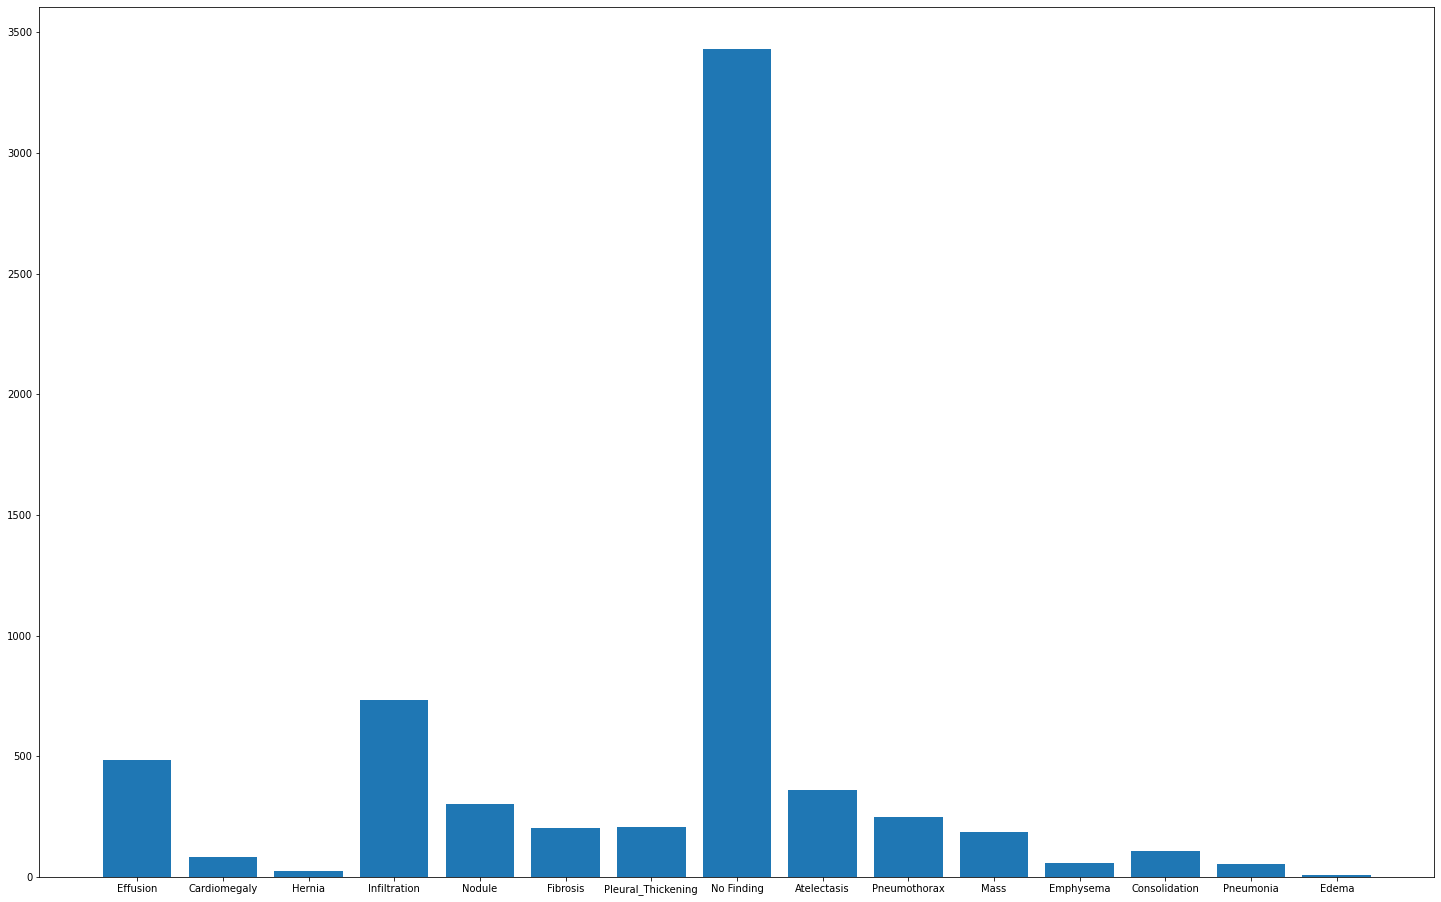

In [ ]:
plt.figure(figsize=(25,16))
plt.bar(label_counts.keys(), label_counts.values(), align='center')
plt.xticks(range(len(label_counts.keys())), list(label_counts.keys()))
plt.show()

In [ ]:
#test DF
all_test_samples = df_test.groupby(by = 'Sample #',axis = 0)
label_counts_test = defaultdict(int)
for sample_num,sample_df in all_test_samples:
  print(f"\nPatient ID: {sample_df['Patient ID'].unique()[0]}")
  label = sample_df["Finding Labels"].values[-1]
  print(f"Label for this sample: {label}")
  print(sample_df[['full_path','Follow-up #','Finding Labels']])
  label_counts_test[label] += 1

Streaming output truncated to the last 5000 lines.
                            full_path  Follow-up #          Finding Labels
2772  images/images6/00012245_002.png            2              No Finding
2773  images/images6/00012245_003.png            3  Infiltration|Pneumonia
2774  images/images6/00012245_004.png            4            Infiltration

Patient ID: 12270
Label for this sample: Infiltration
                            full_path  Follow-up #              Finding Labels
2775  images/images6/00012270_002.png            2  Consolidation|Infiltration
2776  images/images6/00012270_003.png            3      Consolidation|Effusion
2777  images/images6/00012270_004.png            4                Infiltration

Patient ID: 12270
Label for this sample: Effusion
                            full_path  Follow-up #     Finding Labels
2778  images/images6/00012270_004.png            4  Infiltration|Mass
2779  images/images6/00012270_005.png            5               Mass
2780  images/imag

In [ ]:
label_counts_test

defaultdict(int,
            {'Atelectasis': 86,
             'Cardiomegaly': 17,
             'Consolidation': 28,
             'Edema': 3,
             'Effusion': 128,
             'Emphysema': 13,
             'Fibrosis': 44,
             'Hernia': 5,
             'Infiltration': 178,
             'Mass': 57,
             'No Finding': 887,
             'Nodule': 63,
             'Pleural_Thickening': 41,
             'Pneumonia': 15,
             'Pneumothorax': 58})

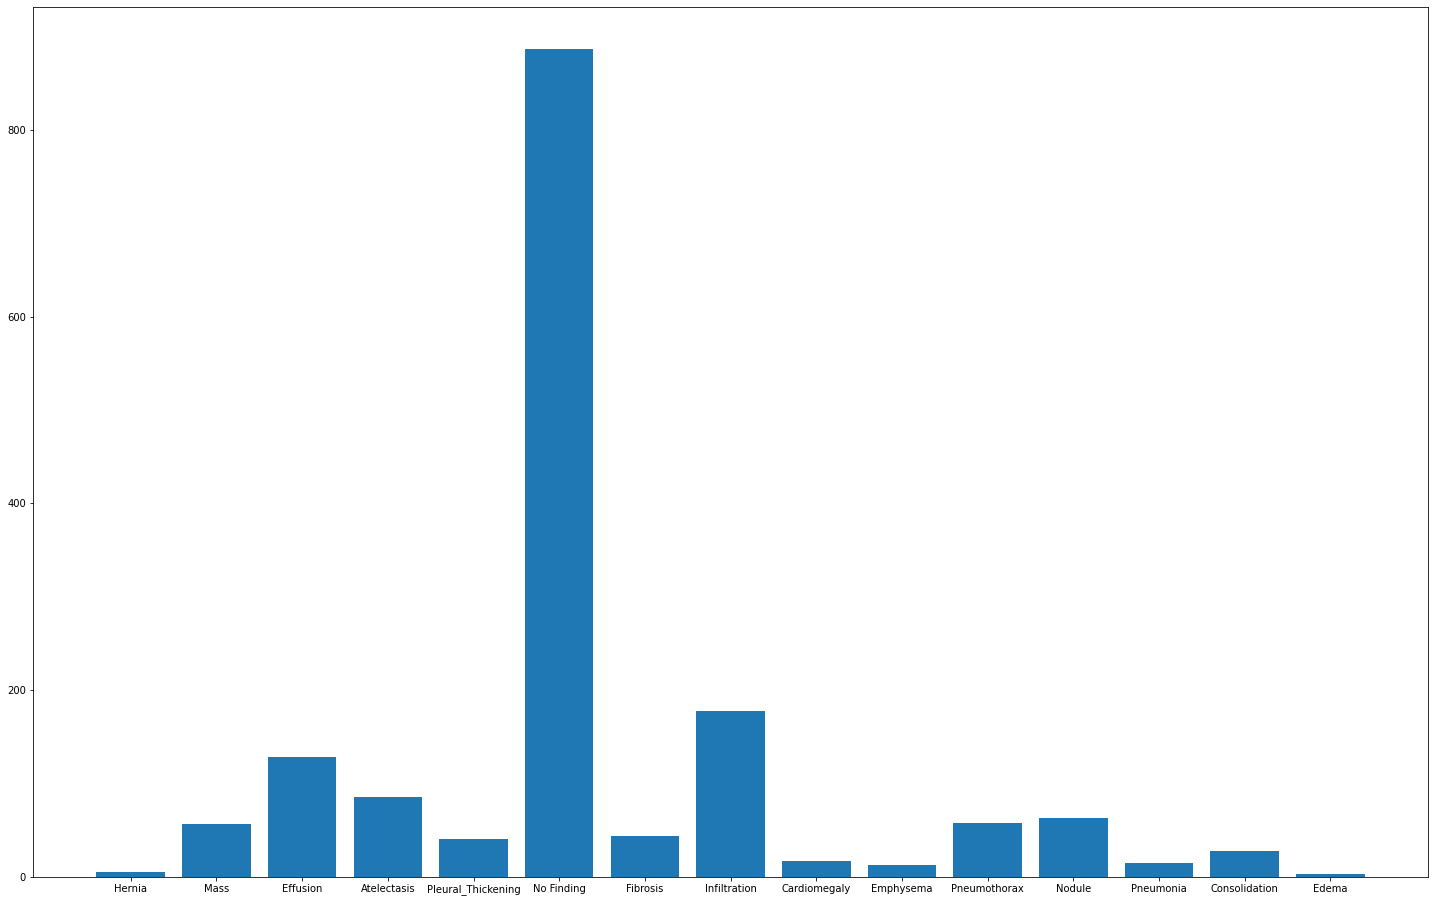

In [ ]:
plt.figure(figsize=(25,16))
plt.bar(label_counts_test.keys(), label_counts_test.values(), align='center')
plt.xticks(range(len(label_counts_test.keys())), list(label_counts_test.keys()))
plt.show()

# **AP images**

## **Adding Full Paths and Some basic Preprocessing**



In [ ]:
os.chdir("/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets/")
!pwd

/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets


In [ ]:
df_ap = pd.read_csv("csv files/with_sampling_index_csv/df_AP.csv")
df_ap

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,1
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,1
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,1
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,2
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,2
...,...,...,...,...,...,...,...,...,...,...,...,...
11710,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,3904
11711,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,3904
11712,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,3905
11713,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,3905


In [ ]:
len(df_ap['Sample #'].unique())

3905

In [ ]:
my_glob = glob.glob('images/images*/*.png')
print('Number of Observations: ', len(my_glob)) # Number of photos should equal 112,120

Number of Observations:  112121


In [ ]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
df_ap['full_path'] = df_ap['Image Index'].map(full_img_paths.get)
df_ap

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_001.png
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_002.png
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_001.png
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11710,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_001.png
11711,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_002.png
11712,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_000.png
11713,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_001.png


In [ ]:
df_ap.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Sample #',
       'full_path'],
      dtype='object')

In [ ]:
df_ap.to_csv("csv files/with_sampling_index_csv/added_paths_AP.csv",index=False)

## **Train/ Test/ Validation dataset creation**

In [ ]:
sample_nums1 = df_ap['Sample #'].unique()
sample_nums1

array([   1,    2,    3, ..., 3903, 3904, 3905])

In [ ]:
TEST_RATIO1 = 0.2

In [ ]:
#split by sample number; then we will
train_sample_nums1,test_sample_nums1 = train_test_split(sample_nums1,test_size = TEST_RATIO1,random_state = 999)
train_sample_nums1
len(train_sample_nums1)

3124

In [ ]:
test_sample_nums1
len(test_sample_nums1)

781

In [ ]:
df_train_all1 = df_ap[df_ap['Sample #'].isin(train_sample_nums1)]
df_test1 = df_ap[df_ap['Sample #'].isin(test_sample_nums1)]

In [ ]:
df_train_all1.reset_index(inplace = True,drop = True)
df_test1.reset_index(inplace = True,drop = True)

In [ ]:
df_train_all1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_001.png
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_002.png
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_001.png
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_001.png
9368,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_002.png
9369,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_000.png
9370,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_001.png


In [ ]:
len(df_train_all1['Sample #'].unique())

3124

In [ ]:
df_test1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000032_004.png,Cardiomegaly|Edema|Effusion,4,32,55,F,AP,2500,2048,0.168,0.168,8,images/images1/00000032_004.png
1,00000032_005.png,No Finding,5,32,55,F,AP,2500,2048,0.168,0.168,8,images/images1/00000032_005.png
2,00000032_006.png,Infiltration,6,32,55,F,AP,2500,2048,0.168,0.168,8,images/images1/00000032_006.png
3,00000032_007.png,Cardiomegaly|Edema|Effusion,7,32,55,F,AP,2500,2048,0.168,0.168,14,images/images1/00000032_007.png
4,00000032_008.png,No Finding,8,32,55,F,AP,2500,2048,0.168,0.168,14,images/images1/00000032_008.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338,00030609_021.png,Atelectasis|Infiltration,21,30609,6,M,AP,3056,2544,0.139,0.139,3887,images/images12/00030609_021.png
2339,00030609_022.png,Infiltration,22,30609,6,M,AP,3056,2544,0.139,0.139,3887,images/images12/00030609_022.png
2340,00030733_001.png,No Finding,1,30733,26,F,AP,3056,2544,0.139,0.139,3900,images/images12/00030733_001.png
2341,00030733_002.png,Consolidation,2,30733,26,F,AP,2544,3056,0.139,0.139,3900,images/images12/00030733_002.png


In [ ]:
len(df_test1['Sample #'].unique())

781

In [ ]:
total_num_train_samples1 = len(df_train_all1['Sample #'].unique())

In [ ]:
train_final_samples1 = train_sample_nums1[:-int(0.1 * total_num_train_samples1)]
val_samples1 = train_sample_nums1[-int(0.1 * total_num_train_samples1):]

In [ ]:
len(train_final_samples1)

2812

In [ ]:
train_final_samples1

array([2005, 1708, 3567, ..., 3144,   25, 2859])

In [ ]:
len(val_samples1)

312

In [ ]:
val_samples1

array([2626, 3247, 3812, 1361,  901,  381, 1415, 2452, 1063, 3903, 2148,
       3093, 3371, 1044,  718, 1422, 2513, 3219, 1605, 1035, 2595, 3410,
       1983, 2227,  270,  298, 2328, 2352, 2232,  366,  169, 1490, 1723,
         40, 3786, 1788, 2472, 2592, 2624, 3621, 1646, 1562,  363, 1324,
       1485, 3435, 1643,   57, 2878, 2699, 2610, 2753, 1362,  433, 3030,
        860, 2119,   65,  582,  663, 2483,  243, 2999, 1719, 1781,  983,
       1554, 3636, 1501, 2125, 1182, 1078, 1828, 3839,  883,  463, 2608,
       2021, 2877,  286, 1901,  290, 2763, 3854, 3165,  494,  524, 1909,
         59,  334,  550, 1610, 2175,  851, 1536,  825, 3552, 3783, 3495,
       1234, 1872, 1191, 2860, 2917,  623, 1757, 2054, 2946, 3579, 2950,
         52, 1969, 3281, 2225, 2454, 1749, 1293,  153, 2800, 2886, 1857,
        890, 3849, 1925, 3291, 1837,  554, 1389, 2121,  144, 1675, 3134,
        775,  910, 2186,  346, 2970,  580, 3732, 2575,  774, 1715,  614,
       3610, 1384,  981, 3034, 2185, 2311,  485,  1

In [ ]:
df_train1 = df_train_all1[df_train_all1['Sample #'].isin(train_final_samples1)]
df_val1 = df_train_all1[df_train_all1['Sample #'].isin(val_samples1)]

In [ ]:
df_train1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_001.png
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_002.png
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_001.png
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_001.png
9368,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_002.png
9369,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_000.png
9370,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_001.png


In [ ]:
df_val1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
30,00000032_005.png,No Finding,5,32,55,F,AP,2500,2048,0.168,0.168,12,images/images1/00000032_005.png
31,00000032_006.png,Atelectasis|Effusion|Infiltration,6,32,55,F,AP,2500,2048,0.168,0.168,12,images/images1/00000032_006.png
32,00000032_007.png,Cardiomegaly,7,32,55,F,AP,2500,2048,0.168,0.168,12,images/images1/00000032_007.png
42,00000032_010.png,No Finding,10,32,55,F,AP,2500,2048,0.168,0.168,17,images/images1/00000032_010.png
43,00000032_011.png,Infiltration,11,32,55,F,AP,2500,2048,0.168,0.168,17,images/images1/00000032_011.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9271,00030609_003.png,No Finding,3,30609,6,M,AP,3056,2544,0.139,0.139,3864,images/images12/00030609_003.png
9272,00030609_004.png,No Finding,4,30609,6,M,AP,2544,3056,0.139,0.139,3864,images/images12/00030609_004.png
9363,00030733_004.png,No Finding,4,30733,26,F,AP,3056,2544,0.139,0.139,3903,images/images12/00030733_004.png
9364,00030733_005.png,No Finding,5,30733,26,F,AP,3056,2544,0.139,0.139,3903,images/images12/00030733_005.png


In [ ]:
len(df_train1['Sample #'].unique())

2812

In [ ]:
len(df_val1["Sample #"].unique())

312

In [ ]:
df_train1.to_csv("csv files/with_sampling_index_csv/AP_train.csv",index=False)
df_test1.to_csv("csv files/with_sampling_index_csv/AP_test.csv",index = False)
df_val1.to_csv("csv files/with_sampling_index_csv/AP_val.csv",index=False)

## **Analyzing the samples for label distributions**


In [ ]:
all_train_samples1 = df_train_all1.groupby(by = 'Sample #',axis = 0)
label_counts1 = defaultdict(int)
for sample_num1,sample_df1 in all_train_samples1:
  print(f"\nPatient ID: {sample_df1['Patient ID'].unique()[0]}")
  label = sample_df1["Finding Labels"].values[-1]
  print(f"Label for this sample: {label}")
  print(sample_df1[['full_path','Follow-up #','Finding Labels']])
  label_counts1[label] += 1

Streaming output truncated to the last 5000 lines.
[3 rows x 3 columns]

Patient ID: 21965
Label for this sample: No Finding
                             full_path  Follow-up # Finding Labels
7311  images/images10/00021965_000.png            0     No Finding
7312  images/images10/00021965_001.png            1    Atelectasis
7313  images/images10/00021965_002.png            2     No Finding

Patient ID: 21965
Label for this sample: No Finding
                             full_path  Follow-up # Finding Labels
7314  images/images10/00021965_002.png            2     No Finding
7315  images/images10/00021965_003.png            3     No Finding
7316  images/images10/00021965_004.png            4     No Finding

Patient ID: 21965
Label for this sample: No Finding
                             full_path  Follow-up # Finding Labels
7317  images/images10/00021965_003.png            3     No Finding
7318  images/images10/00021965_004.png            4     No Finding
7319  images/images10/00021965_0

In [ ]:
label_counts1

defaultdict(int,
            {'Atelectasis': 301,
             'Cardiomegaly': 63,
             'Consolidation': 204,
             'Edema': 89,
             'Effusion': 357,
             'Emphysema': 18,
             'Fibrosis': 28,
             'Infiltration': 627,
             'Mass': 86,
             'No Finding': 1051,
             'Nodule': 122,
             'Pleural_Thickening': 48,
             'Pneumonia': 44,
             'Pneumothorax': 86})

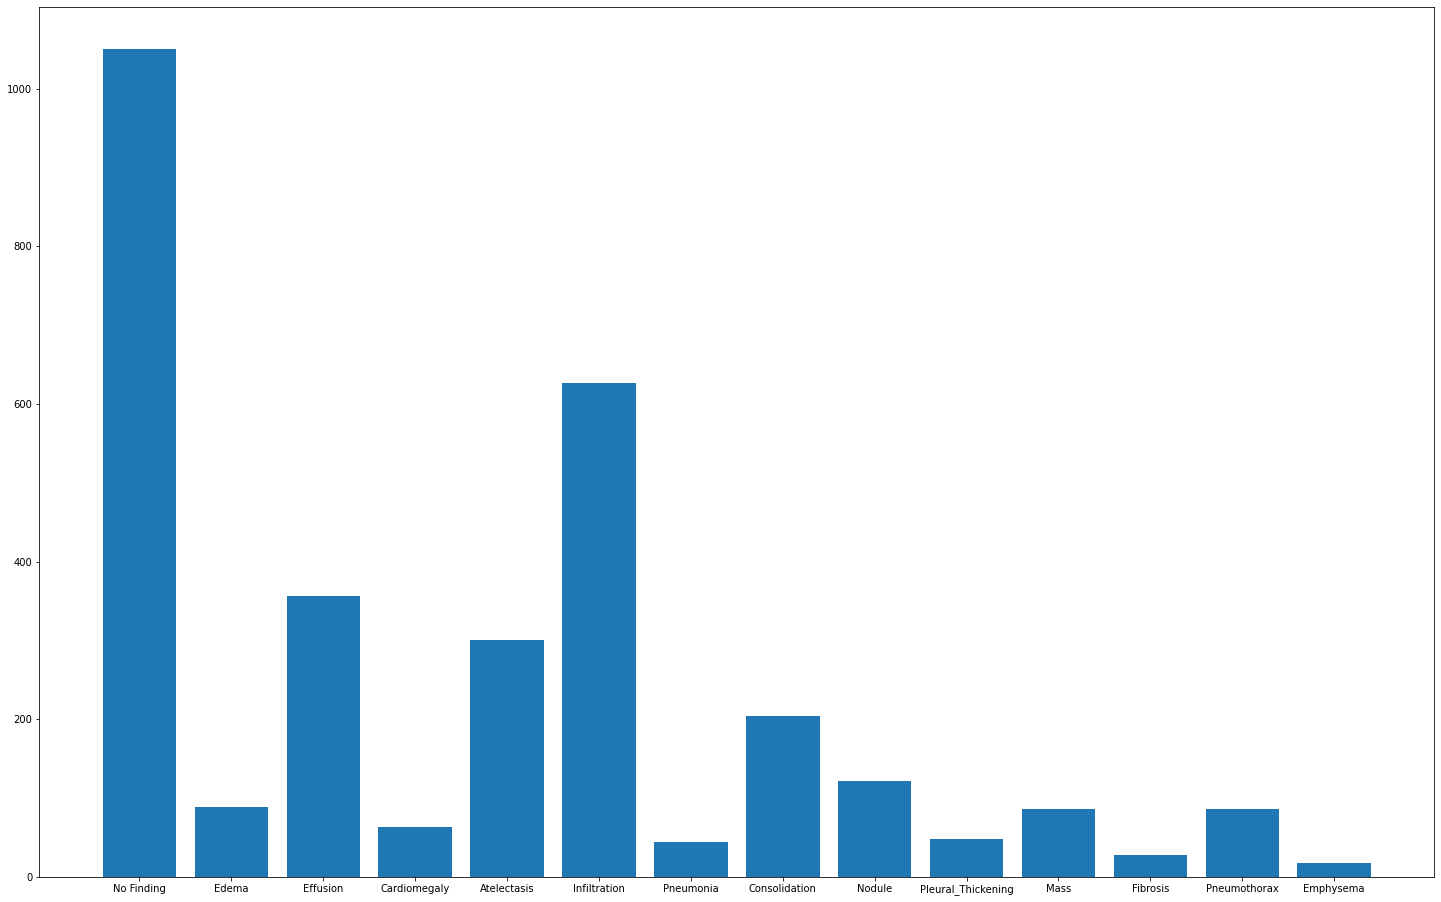

In [ ]:
plt.figure(figsize=(25,16))
plt.bar(label_counts1.keys(), label_counts1.values(), align='center')
plt.xticks(range(len(label_counts1.keys())), list(label_counts1.keys()))
plt.show()

In [ ]:
#test DF
all_test_samples1 = df_test1.groupby(by = 'Sample #',axis = 0)
label_counts_test1 = defaultdict(int)
for sample_num1,sample_df1 in all_test_samples1:
  print(f"\nPatient ID: {sample_df1['Patient ID'].unique()[0]}")
  label = sample_df1["Finding Labels"].values[-1]
  print(f"Label for this sample: {label}")
  print(sample_df1[['full_path','Follow-up #','Finding Labels']])
  label_counts_test1[label] += 1

Streaming output truncated to the last 5000 lines.
283  images/images2/00002072_001.png  ...  Cardiomegaly|Infiltration|Nodule
284  images/images2/00002072_002.png  ...                     Consolidation

[3 rows x 3 columns]

Patient ID: 2072
Label for this sample: Nodule
                           full_path  ...                    Finding Labels
285  images/images2/00002072_000.png  ...                       Atelectasis
286  images/images2/00002072_001.png  ...  Cardiomegaly|Infiltration|Nodule
287  images/images2/00002072_002.png  ...                            Nodule

[3 rows x 3 columns]

Patient ID: 2072
Label for this sample: Atelectasis
                           full_path  ...                     Finding Labels
288  images/images2/00002072_002.png  ...  Consolidation|Infiltration|Nodule
289  images/images2/00002072_003.png  ...              Effusion|Infiltration
290  images/images2/00002072_004.png  ...                        Atelectasis

[3 rows x 3 columns]

Patient ID: 2072


In [ ]:
label_counts_test1

defaultdict(int,
            {'Atelectasis': 77,
             'Cardiomegaly': 14,
             'Consolidation': 49,
             'Edema': 18,
             'Effusion': 92,
             'Emphysema': 6,
             'Fibrosis': 6,
             'Infiltration': 156,
             'Mass': 15,
             'No Finding': 273,
             'Nodule': 36,
             'Pleural_Thickening': 12,
             'Pneumonia': 13,
             'Pneumothorax': 14})

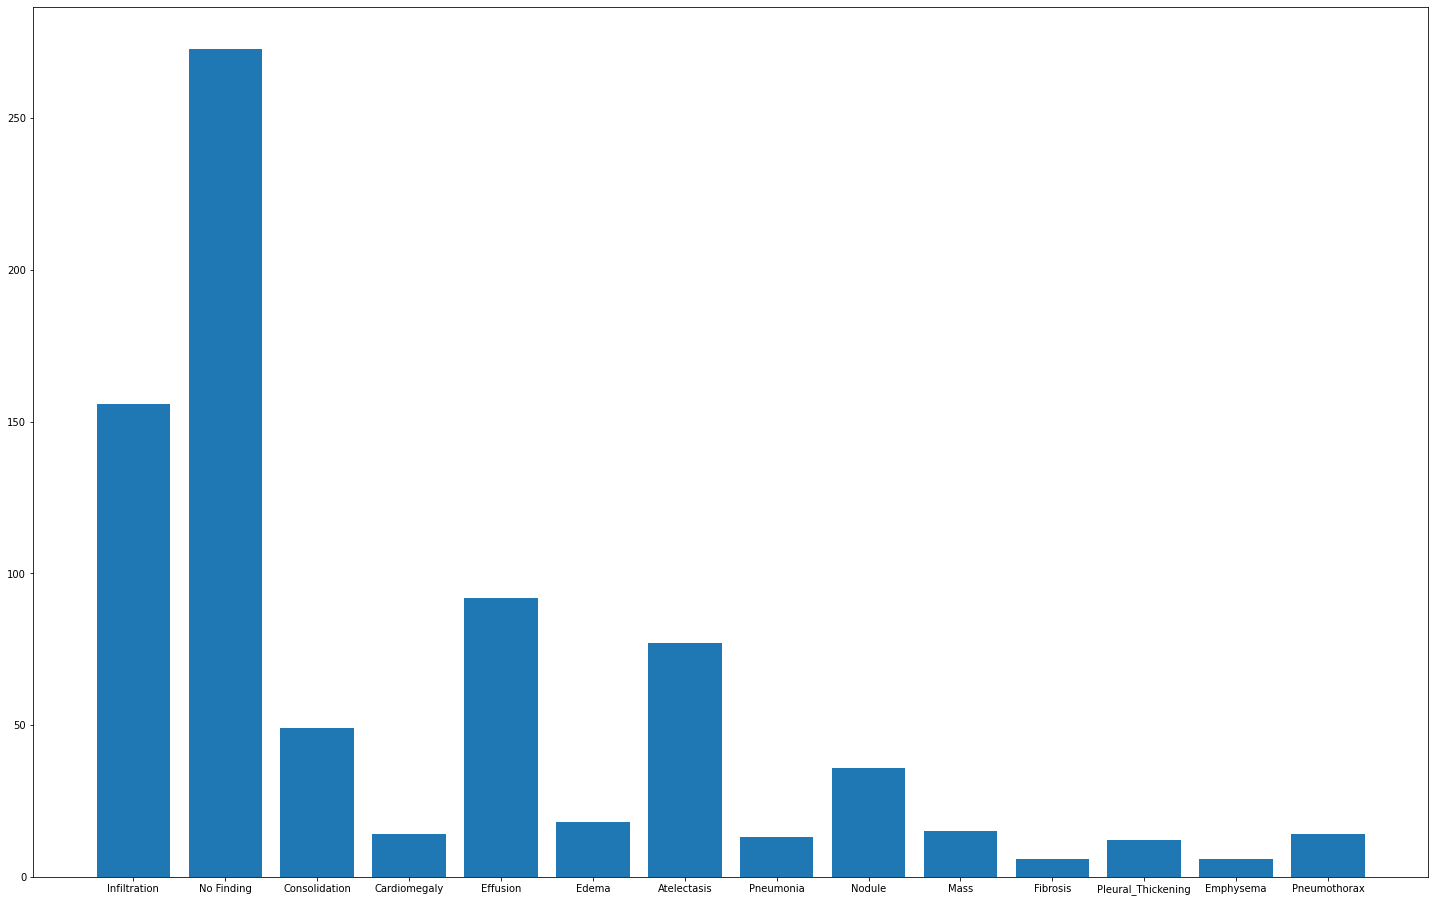

In [ ]:
plt.figure(figsize=(25,16))
plt.bar(label_counts_test1.keys(), label_counts_test1.values(), align='center')
plt.xticks(range(len(label_counts_test1.keys())), list(label_counts_test1.keys()))
plt.show()

# **Saving each image as an array**

In [ ]:
!ls

drive  sample_data


In [ ]:
os.chdir("/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets/")
!pwd

/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets


In [ ]:
!ls

 AP_images.pkl			 images_rescaled
 bin_files			 images_zip_files
'csv files'			 PA_images_from3362till5427.pkl
 Data_Entry_2017_v2020.gsheet	 PA_images_from5427till7681.pkl
 Dataset_Process_Details.ipynb	 PA_images_from7682to8682.pkl
 Filter_Dataset_script.ipynb	 PA_images_till3362.pkl
 images				 Sample_Set_Images.ipynb


In [ ]:
IMAGE_SIZE = (128,128)

## **PA**

In [ ]:
df_pa = pd.read_csv("csv files/with_sampling_index_csv/added_paths_PA.csv")
df_pa

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,1,images/images1/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,1,images/images1/00000001_001.png
2,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,1,images/images1/00000001_002.png
3,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,2,images/images1/00000001_000.png
4,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,2,images/images1/00000001_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24337,00030427_001.png,No Finding,1,30427,70,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_001.png
24338,00030427_002.png,No Finding,2,30427,71,M,PA,2021,2021,0.194311,0.194311,8113,images/images12/00030427_002.png
24339,00030434_000.png,Atelectasis,0,30434,53,M,PA,2021,2021,0.194308,0.194308,8114,images/images12/00030434_000.png
24340,00030434_001.png,Atelectasis,1,30434,53,M,PA,2021,2021,0.194311,0.194311,8114,images/images12/00030434_001.png


In [ ]:
len(df_pa['full_path'].unique())

12151

In [ ]:
len(df_pa['Image Index'].unique())

12151

In [ ]:
!pwd

/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets


In [ ]:
IMAGE_SIZE = (128,128)

In [ ]:
all_files = df_pa['full_path'].unique()
all_files[:10]

array(['images/images1/00000001_000.png',
       'images/images1/00000001_001.png',
       'images/images1/00000001_002.png',
       'images/images1/00000003_000.png',
       'images/images1/00000003_001.png',
       'images/images1/00000003_002.png',
       'images/images1/00000003_003.png',
       'images/images1/00000003_004.png',
       'images/images1/00000003_005.png',
       'images/images1/00000003_006.png'], dtype=object)

In [ ]:
PA_image_path = 'images_pickled/'

In [ ]:
all_PA_imgs = defaultdict()

In [ ]:
for filename in tqdm(all_files[:]):
  image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image,IMAGE_SIZE)
  filename_resave = filename.split('/')[-1]
  all_PA_imgs[filename_resave] = image
  del image

In [ ]:
len(all_PA_imgs.keys())

In [ ]:
file_to_save = 'PA_images.pkl'
with open(file_to_save,'wb') as f:
  pickle.dump(all_PA_imgs,f)

## **AP**

In [ ]:
df_ap = pd.read_csv("csv files/with_sampling_index_csv/added_paths_AP.csv")
df_ap

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sample #,full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_001.png
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,1,images/images1/00000032_002.png
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_001.png
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,2,images/images1/00000032_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11710,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_001.png
11711,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,3904,images/images12/00030770_002.png
11712,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_000.png
11713,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,3905,images/images12/00030772_001.png


In [ ]:
len(df_ap['full_path'].unique())

3768

In [ ]:
len(df_ap['Image Index'].unique())

3768

In [ ]:
all_files = df_ap['full_path'].unique()
all_files[:10]

array(['images/images1/00000032_000.png',
       'images/images1/00000032_001.png',
       'images/images1/00000032_002.png',
       'images/images1/00000032_003.png',
       'images/images1/00000032_004.png',
       'images/images1/00000032_005.png',
       'images/images1/00000032_006.png',
       'images/images1/00000032_007.png',
       'images/images1/00000032_008.png',
       'images/images1/00000032_009.png'], dtype=object)

In [ ]:
all_AP_imgs = defaultdict()

In [ ]:
!ls

 bin_files			 images
'csv files'			 images_rescaled
 Data_Entry_2017_v2020.gsheet	 images_zip_files
 Dataset_Process_Details.ipynb	 Sample_Set_Images.ipynb
 Filter_Dataset_script.ipynb


In [ ]:
for filename in tqdm(all_files[:]):
  image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image,IMAGE_SIZE)
  filename_resave = filename.split('/')[-1]
  all_AP_imgs[filename_resave] = image
  del image

100%|██████████| 3768/3768 [01:04<00:00, 58.87it/s]


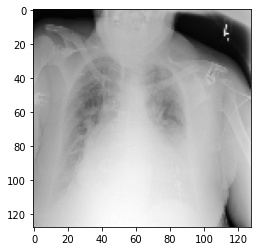

In [ ]:
plt.imshow(all_AP_imgs['00000032_000.png'],cmap="gray")

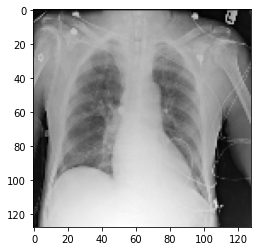

In [ ]:
plt.imshow(all_AP_imgs['00000193_004.png'],cmap='gray')

In [ ]:
with open("AP_images.pkl",'wb') as f:
  pickle.dump(all_AP_imgs,f)

In [ ]:
!ls

 AP_images.pkl			 Filter_Dataset_script.ipynb
 bin_files			 images
'csv files'			 images_rescaled
 Data_Entry_2017_v2020.gsheet	 images_zip_files
 Dataset_Process_Details.ipynb	 Sample_Set_Images.ipynb
